In [1]:
#!/usr/bin/env python
"""choose_skies.ipynb: a notebook to look at detected GW skies """

__author__ = "Chiara M. F. Mingarelli"
__copyright__ = "Copyright 2017, GWASAP project"
__credits__ = ["Chiara Mingarelli"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Chiara Mingarelli"
__email__ = "mingarelli@gmail.com"
__status__ = "prototype"

In [2]:
#necessary imports

from __future__ import division
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi
import numpy as np
import statsmodels.api as sm
from scipy.interpolate import interp1d
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
import healpy as hp
import plot_mpl2
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import collections


%matplotlib inline
%config InlineBackend.figure_format = "retina"

#methods to normalize histograms
def hist_weight(lst):
    return np.ones_like(lst)/len(lst)

def auto_bin(bin_size, min_edge, max_edge):
    #bin_size = 0.05; min_edge = -3.5; max_edge = -1
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)
    return bin_list

In [3]:
#Paramters for so all plots look similar

fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 4,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [4]:
#use file produced at the end of step 2
data_filename = "../../test_data/MM13_big_test.txt" #all the realizations
det_filename = "../../detectedSkies/new_format_detectedSkies0126.txt" #the file with the detected skies data
det_sky = np.genfromtxt(det_filename)

In [5]:
def find_nearest(array,value):
    #returns index of matching value in array
    idx = (np.abs(array-value)).argmin()
    return idx 

In [6]:
def find_gal_idx(nameList, name):
    ans = [i for i, x in enumerate(nameList) if x == name]
    return ans

def find_gal_dec_idx(nameList, dec):
    ans = [i for i, x in enumerate(nameList) if x >= dec]
    return ans

def find_gal_dec_idx_neg(nameList, dec):
    ans = [i for i, x in enumerate(nameList) if x <= dec]
    return ans

In [7]:
#collects detetced source name and its corresponding realization number to find where it was detetcted
det_name = np.genfromtxt(det_filename, usecols = (10), dtype = str,)
det_index = np.genfromtxt(det_filename, usecols = (4), dtype=None)
det_name = det_name.tolist()
det_DEC = np.genfromtxt(det_filename, usecols = (1), dtype=None)
#det_DEC = det_DEC*180/pi

In [8]:
det_name

['2MASXJ2024063',
 'ESO045-011',
 'NGC6251',
 'ESO035-011',
 'UGC10471',
 '2MASXJ2024063',
 'ESO005-010',
 'PGC068764',
 'PGC237369',
 'PGC242280',
 'NGC6251',
 '2MASXJ2024063',
 'IC1143',
 'NGC1956',
 'NGC4382',
 'PGC228287',
 'NGC1316',
 'PGC2772950',
 '2MASXJ2024063',
 '2MASXJ2024063',
 '2MASXJ2024063',
 '2MASXJ2024063',
 '2MASXJ2024063']

In [9]:
#finds all galaxies lying outside of dec = 70 (interpolating makes these unreliable sources)
rm_dec_pos = find_gal_dec_idx(det_DEC, 70.0)
rm_dec_neg = find_gal_dec_idx_neg(det_DEC, -70.0)

In [10]:
#turn DEC into point for plot
det_DEC = det_sky[:,1]*180/pi

In [11]:
# concatenate ±70 deg in declination galaxy indices and remove them
all_bad_idx = rm_dec_neg + rm_dec_pos 
new_det_sky = np.delete(det_sky, all_bad_idx ,0)
new_det_sky_name = np.delete(det_name, all_bad_idx,0)
new_det_sky_file= np.delete(det_index, all_bad_idx,0)

In [12]:
# Parameters of detected skies once the list has had the bad galaxies removed
det_RA = new_det_sky[:,0]*180/pi
det_freq = new_det_sky[:,2]
det_strain = new_det_sky[:,3]
mchirp_rec = new_det_sky[:,5]
q_rec = new_det_sky[:,6]
det_name = new_det_sky_name
det_dist = new_det_sky[:,7]
mstar_list = new_det_sky[:,8]
save_p= new_det_sky[:,9]
det_file = new_det_sky_file

In [13]:
# load pulsar positions on the sky
p_pos = np.genfromtxt("../pulsar_positions.txt", skip_header=0, usecols = (1,2) )
p_RA = p_pos[:,0]
p_DEC = pi/2-p_pos[:,1]
p_name = np.genfromtxt("../pulsar_positions.txt", skip_header=0, usecols = (0), dtype = 'S13' )

Mp_pos = np.genfromtxt("../more_pulsars.txt", usecols = (1,2) )
Mp_RA = Mp_pos[:,0]
Mp_DEC = Mp_pos[:,1]
Mp_name = np.genfromtxt("../more_pulsars.txt", usecols = (0), dtype = 'S13' )

In [15]:
# Make maps of all the detected sources
# To plot a single sky here, set up for multiple detected skies - uncomment below line with desired data, and comment out the current for loop line 

# det_freq = []
# det_freq.append(3.78653726523e-09)
# for ii in range(1):

#plots each detected source onto a map 
for ii in range(len(det_RA)):
    scat_sky=np.genfromtxt("../../scatter_maps/scatterData_freq_"+str(det_freq[ii])+"Hz.dat")
    scat_ra = scat_sky[:,0]
    scat_dec = scat_sky[:,1]
    scat_strain = np.log10(scat_sky[:,2])
    
    ax = plt.subplot(111, projection='astro mollweide')
    colors = scat_strain
    sky=plt.scatter(scat_ra, scat_dec, c = colors, edgecolors='none', cmap ='viridis_r',  rasterized=True)
   
    plt.suptitle(r"$\log_{10}(h)$, GW sky at $f=$ "+str('%.2e' %det_freq[ii])+" Hz", y=0.3)
    #plt.scatter(Mp_RA*pi/180, Mp_DEC*pi/180, color ='white', marker = "*", alpha=1)
    plt.scatter(p_RA, p_DEC, marker = "*", color = '#ff7f0e', s = 35)
    plt.scatter(det_RA[ii]*pi/180, det_DEC[ii]*pi/180, marker = "*", color = "white", s = 35)
    plt.colorbar(sky, orientation = 'horizontal')
    
    ax.grid(linewidth=0.5)
    
    
    plt.savefig("plots/herc_skies/"+str(ii)+"_"+str(det_name[ii])+"_wPulsars_test07.pdf", dpi=400)
    plt.clf()
    #plt.savefig("plots_MM13/allEPTA_pulsars_MM13_1.pdf", dpi=400)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaco

<Figure size 244.354x151.019 with 0 Axes>

## Visually inspect resultant GW skies. Are the sources lying on e.g. interpolation flares?

In [16]:
# indices of skies which failed 2nd inspection, you need to put these in by hand
# the 2nd inspection: 
    #look at the maps produced by the previous function, 
    #if at source it at one of the poles or in a flare ->> remove it (add the index to sec_insp_idx)

#bad indexs
sec_insp_idx = [] #ex) [1, 5, 9, 16, ..., 456]

In [17]:
#the final list of potential skies and their realization numbers
final_sky = np.delete(new_det_sky, sec_insp_idx,0)
final_sky_name = np.delete(new_det_sky_name, sec_insp_idx,0)
final_sky_indexes = np.delete(new_det_sky_file, sec_insp_idx,0)

In [18]:
# Retreives the data from the data file and seperates the data by reliaztaion number


count = 0 #variable used to count number of sources per realization
file_s = [] #numbers of sources per relaization
RA = []
DEC = []
freq = []
strain = []
mchirp_rec = []
q_rec = []
gal_cat = [] #string
dist = []
mstar = []
save_p = []
gal_choice = []
T_z = []
mergeRate = []
t2c = []
z = []
stall = []  
stall_num = 0

#temps used to help seperate data by relalization
temp_RA = []
temp_DEC = []
temp_freq = []
temp_strain = []
temp_mchirp_rec = []
temp_q_rec = []
temp_gal_cat = [] #string
temp_dist = []
temp_mstar = []
temp_save_p = []
temp_gal_cat = []
temp_gal_choice = []
temp_T_z = []
temp_mergRate = []
temp_t2c = []
temp_z = []
temp_file_s = []

with open(data_filename) as f:
    
    temp_RA = []
    temp_DEC = []
    temp_freq = []
    temp_strain = []
    temp_mchirp_rec = []
    temp_q_rec = []
    temp_gal_cat = [] #string
    temp_dist = []
    temp_mstar = []
    temp_save_p = []
    temp_gal_choice = []
    temp_T_z = []
    temp_mergRate = []
    temp_t2c = []
    temp_z = []
    temp_file_s = []
    
    for line in f:
        if len(line) < 50:
            
            #add the collected data to the real lists
            
            file_s.append(count)
            stall.append(stall_num)
            RA.append(temp_RA) #phi, add pi to this for healpix maps
            DEC.append(temp_DEC) #theta
            freq.append(temp_freq)
            strain.append(temp_strain)
            mchirp_rec.append(temp_mchirp_rec)
            q_rec.append(temp_q_rec)
            gal_cat.append(temp_gal_cat)
            dist.append(temp_dist)
            mstar.append(temp_mstar)
            save_p.append(temp_save_p)
            gal_choice.append(temp_gal_choice)
            T_z.append(temp_T_z)
            mergeRate.append(temp_mergRate) 
            t2c.append(temp_t2c)
            z.append(temp_z)
            
            #reset the temp lists
            
            temp_RA = []
            temp_DEC = []
            temp_freq = []
            temp_strain = []
            temp_mchirp_rec = []
            temp_q_rec = []
            temp_gal_cat = [] #string
            temp_dist = []
            temp_mstar = []
            temp_save_p = []
            temp_gal_cat = []
            temp_gal_choice = []
            temp_T_z = []
            temp_mergRate = []
            temp_t2c = []
            temp_z = []
            temp_file_s = []
            count = 0
            
        else:
            
            #data is split into its corresponding lists
            
            splitted = line.split(" ") 
    
            stall_num = int(splitted[-1])
            temp_RA.append(float(splitted[0])) #phi, add pi to this for healpix maps
            temp_DEC.append(float(splitted[1])) #theta
            temp_freq.append(float(splitted[2]))
            temp_strain.append(float(splitted[3]))
            temp_mchirp_rec.append(float(splitted[4]))
            temp_q_rec.append(float(splitted[5]))
            temp_gal_cat.append(str(splitted[6]))
            temp_dist.append(float(splitted[7]))
            temp_mstar.append(float(splitted[8]))
            temp_save_p.append(float(splitted[9]))
            temp_gal_choice.append(float(splitted[10]))
            temp_T_z.append(float(splitted[11]))
            temp_mergRate.append(float(splitted[12])) 
            temp_t2c.append(float(splitted[13]))
            temp_z.append(float(splitted[14]))
            count+=1
            
            
#adding final realization
file_s.append(count)
stall.append(stall_num)
RA.append(temp_RA) #phi, add pi to this for healpix maps
DEC.append(temp_DEC) #theta
freq.append(temp_freq)
strain.append(temp_strain)
mchirp_rec.append(temp_mchirp_rec)
q_rec.append(temp_q_rec)
gal_cat.append(temp_gal_cat)
dist.append(temp_dist)
mstar.append(temp_mstar)
save_p.append(temp_save_p)
gal_choice.append(temp_gal_choice)
T_z.append(temp_T_z)
mergeRate.append(temp_mergRate) 
t2c.append(temp_t2c)
z.append(temp_z)


#deleting intial empty array ex) stall = [[], [2], [3]] --> [[2], [3]]
file_s = file_s[1:]
stall = stall[1:]
RA = RA[1:]
DEC = DEC[1:]
freq = freq[1:]
strain = strain[1:]
mchirp_rec = mchirp_rec[1:]
q_rec = q_rec[1:]
gal_cat = gal_cat[1:]
dist = dist[1:]
mstar = mstar[1:]
save_p = save_p[1:]
gal_choice = gal_choice[1:]
T_z = T_z[1:]
mergeRate = mergeRate[1:]
t2c = t2c[1:]
z = z[1:]

In [19]:
#variables to use for final detected skies 
#has data from the ENTIRE sky

final_det_file_s = [] #numbers of sources per relaization
final_det_RA = []
final_det_DEC = []
final_det_freq = []
final_det_strain = []
final_det_mchirp_rec = []
final_det_q_rec = []
final_det_gal_cat = [] #string
final_det_dist = []
final_det_mstar = []
final_det_save_p = []
final_det_gal_choice = []
final_det_T_z = []
final_det_mergeRate = []
final_det_t2c = []
final_det_z = []
final_det_file_s = []
final_det_stall = []  


In [20]:
#collects just the data from skies that we deem to have final dected sources, 
dest_file_data = "../../detectedSkies/final_skies/all_final_sky_data_new0126.txt"

result_file_data = open(dest_file_data, "a+")

for index in final_sky_indexes:
    final_det_file_s.append(file_s[index])
    final_det_RA.append(RA[index])
    final_det_DEC.append(DEC[index])
    final_det_freq.append(freq[index])
    final_det_strain.append(strain[index])
    final_det_mchirp_rec.append(mchirp_rec[index])
    final_det_q_rec.append(q_rec[index])
    final_det_gal_cat.append(gal_cat[index])
    final_det_dist.append(dist[index])
    final_det_mstar.append(mstar[index])
    final_det_save_p.append(save_p[index])
    final_det_gal_choice.append(gal_choice[index])
    final_det_T_z.append(T_z[index])
    final_det_mergeRate.append(mergeRate[index])
    final_det_t2c.append(t2c[index])
    final_det_z.append(z[index])
    final_det_stall.append(stall[index])
    
    temp_arr = np.zeros(len(RA[index]))
    temp_arr.fill(index)
    
    
    for R, D, N, DI, E, M, Q, F, H, FN, P in zip (RA[index], DEC[index], gal_cat[index], dist[index], mstar[index], mchirp_rec[index], q_rec[index], freq[index], strain[index], temp_arr, save_p[index]):
        result_file_data.write('{0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10}\n'.format(R, D, N, DI, E, M, Q, F, H, FN, P))
     
    result_file_data.write("\n")
    
result_file_data.close()
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_f

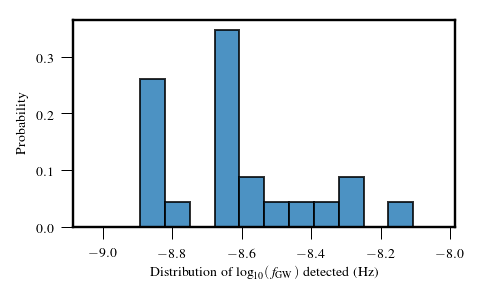

In [21]:
#distribution of frequencies where sources were detected

bin_list = auto_bin(0.07,-9,-8)
weights = hist_weight(np.log10(det_freq))
plt.hist(np.log10(det_freq),bin_list, align='left',  alpha=0.8, edgecolor = 'black', weights = weights)
plt.xlabel(r"Distribution of $\log_{10}(f_\mathrm{GW})$ detected (Hz)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig("plots_mm13_34/step_2/distribution_freq_mm13_34.pdf")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_f

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

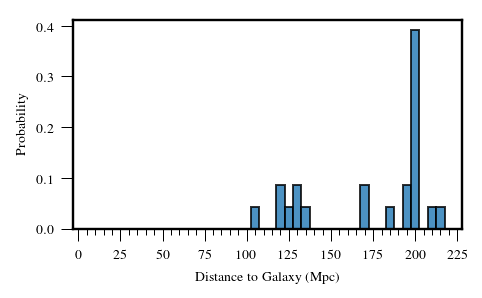

In [22]:
#Distributions of distance for detected skies
fig = plt.figure()

bin_list = auto_bin(5,10,220)
weights = hist_weight(det_dist)
ax = fig.add_subplot(111)
plt.hist(det_dist, bin_list, weights=weights, alpha = 0.8, align='left', edgecolor = 'black')

majorLocator = MultipleLocator(25)
minorLocator = MultipleLocator(5)

ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)

plt.xlabel("Distance to Galaxy (Mpc)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("plots_mm13_34/step_3/distribution_dist_mm13_34.pdf")

In [23]:
##turns det_gat_cat into a 1-D np array
catalog_list = []

for i in det_name:
    catalog_list.append(i)

In [24]:
#creates the histogram data
threshhold = 1 #the limit for number of times the galaxy was detected 
                #ex) threshold = 20, the galaxies appeared over 20 times
    
histo_data = dict((x, catalog_list.count(x)) for x in catalog_list if (catalog_list.count(x) > threshhold) )

In [25]:
d = histo_data
print(len(d.values()))

2


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

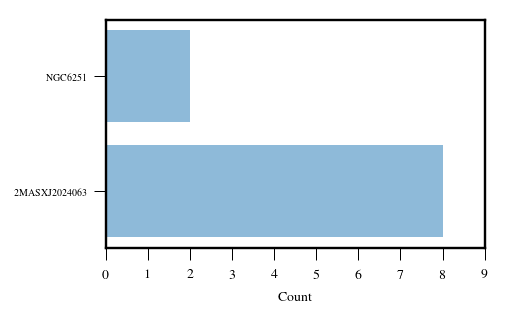

In [26]:
#plots the number of times (> threshold) a galaxy appeared
#plot version 1
X = np.arange(len(histo_data))
fig = plt.figure()
ax = fig.add_subplot(111)

values = list(histo_data.values())

ax.barh(X, values, alpha=0.5, linewidth = 0.5)
ax.set_yticks(X)

plt.setp(ax.get_yticklabels(), fontsize=5)
ax.set_yticklabels(histo_data.keys())

majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(1)

ax.xaxis.set_minor_locator(minorLocator)

ax.xaxis.set_major_locator(majorLocator)
xmax = max(histo_data.values()) + 1

plt.xlim(0, xmax)
plt.xlabel("Count")

#plt.savefig("plots_mm13_34/step_3/gal_count_mm13_34.pdf")
plt.show()


In [27]:
#plots the counts for each galaxy again, with different format
histo_data = sorted(histo_data.items(), key=lambda x:x[1]) # sort histogram by count

value = np.zeros([len(histo_data)])

label = []

for j in range(len(histo_data)):
    value[j] = histo_data[j][1]
    label.append(histo_data[j][0])

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

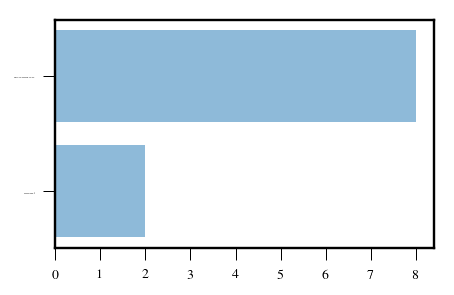

In [28]:
#plots the number of times (over threshold) a galaxy appeared
#plot version 2

X = np.arange(len(value))
fig = plt.figure()

ax = fig.add_subplot(111)
ax.barh(X, value, alpha=0.5, linewidth = 0.4)
ax.set_yticks(X)

plt.setp(ax.get_yticklabels(), fontsize=1.5)

ax.set_yticklabels(label)

majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(1)

ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)

#plt.savefig("plots_mm13_34/step_3/sorted_gal_mm13_34.pdf")

In [29]:
# Make LaTex tables for paper by adding  & and \\
det_nameR = []
det_distR = []
mstar_listR = []
mchirp_recR = []
q_recR = []
det_freqR = []
det_strainR = []

In [30]:
# final galaxy list and parameters

all_det_RA = final_sky[:,0]*180/pi
all_det_DEC = final_sky[:,1]*180/pi
all_det_freq = final_sky[:,2]
all_det_strain = final_sky[:,3]
all_det_mchirp_rec = final_sky[:,5]
all_det_q_rec = final_sky[:,6]
all_det_name = final_sky_name
all_det_dist = final_sky[:,8]
all_det_mstar = final_sky[:,9]
all_det_save_p= final_sky[:,10]

In [ ]:
# Save final sources only
dest_file = "../../detectedSkies/final_skies/mm13_mbul_final_test0126.txt"    

result_file = open(dest_file, "a+") # the a+ allows you to create the file and write to it.

for R, DEC, N, D, E, M, Q, F, H, FN in zip (all_det_RA, all_det_DEC, all_det_name, all_det_dist, all_det_mstar, all_det_mchirp_rec, all_det_q_rec, all_det_freq, all_det_strain, final_sky_indexes):
    result_file.write('{0} {1} {2} {3} {4} {5} {6} {7} {8} {9}\n'.format(R,DEC, N, D, E, M, Q, F, H, FN))
result_file.close()